# PS reconstruction, non-Gaussian beam

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir =  os.path.join('data', 'non_gaussian_beam', 'normal')
p0c = 43.36e6 # reference momentum in eV/c

n_particles = 100_000

gt_beam = create_beam(
    base_yaml = os.path.join(yaml_dir, 'base.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = n_particles,
)

data = gt_beam.data.clone()
gt_beam.data = data * 0.5

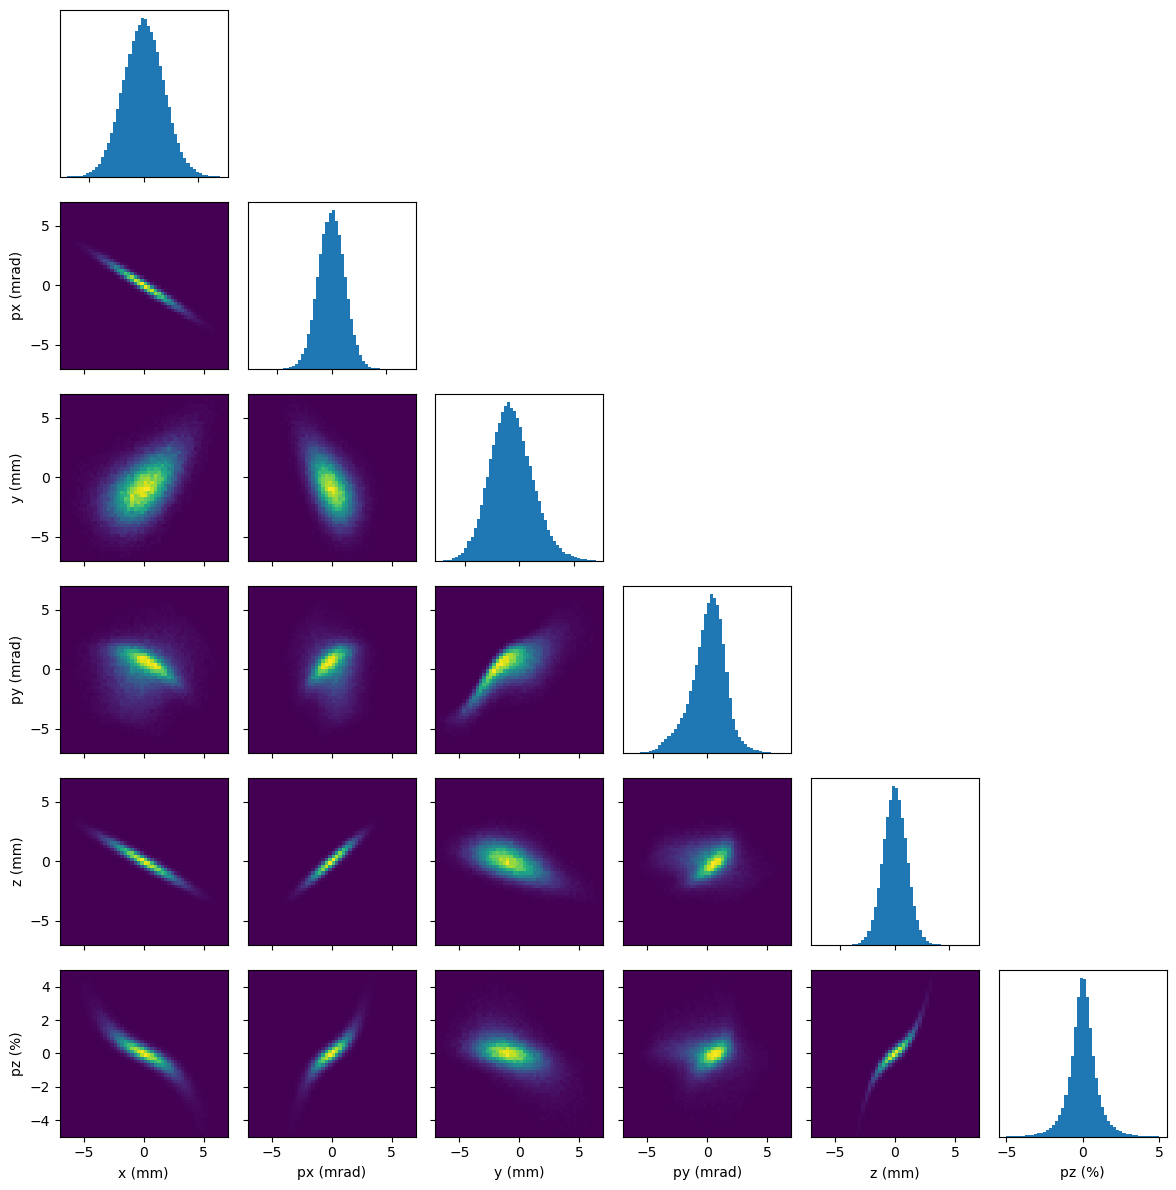

In [3]:
#plot gt beam
lims = np.array([[-7, 7],
                 [-5, 5],
                 [-7, 7],
                 [-6, 6],
                 [-3, 3],
                 [-3, 3]]) 

slims = np.array([[-7, 7],
                 [-7, 7],
                 [-7, 7],
                 [-7, 7],
                 [-7, 7],
                 [-50, 50]]) 

fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = slims*1e-3,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 =     8.75034
k2 =  -24.402993
k3 =   25.628154

# k1 =     6.10308
# k2 =  -24.441689
# k3 =   25.971829

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-25, 25, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan training data

In [6]:
torch.cuda.empty_cache()

In [7]:
lims

array([[-7,  7],
       [-5,  5],
       [-7,  7],
       [-6,  6],
       [-3,  3],
       [-3,  3]])

-7 7
-5 5
-7 7
-6 6
-3 3
-3 3


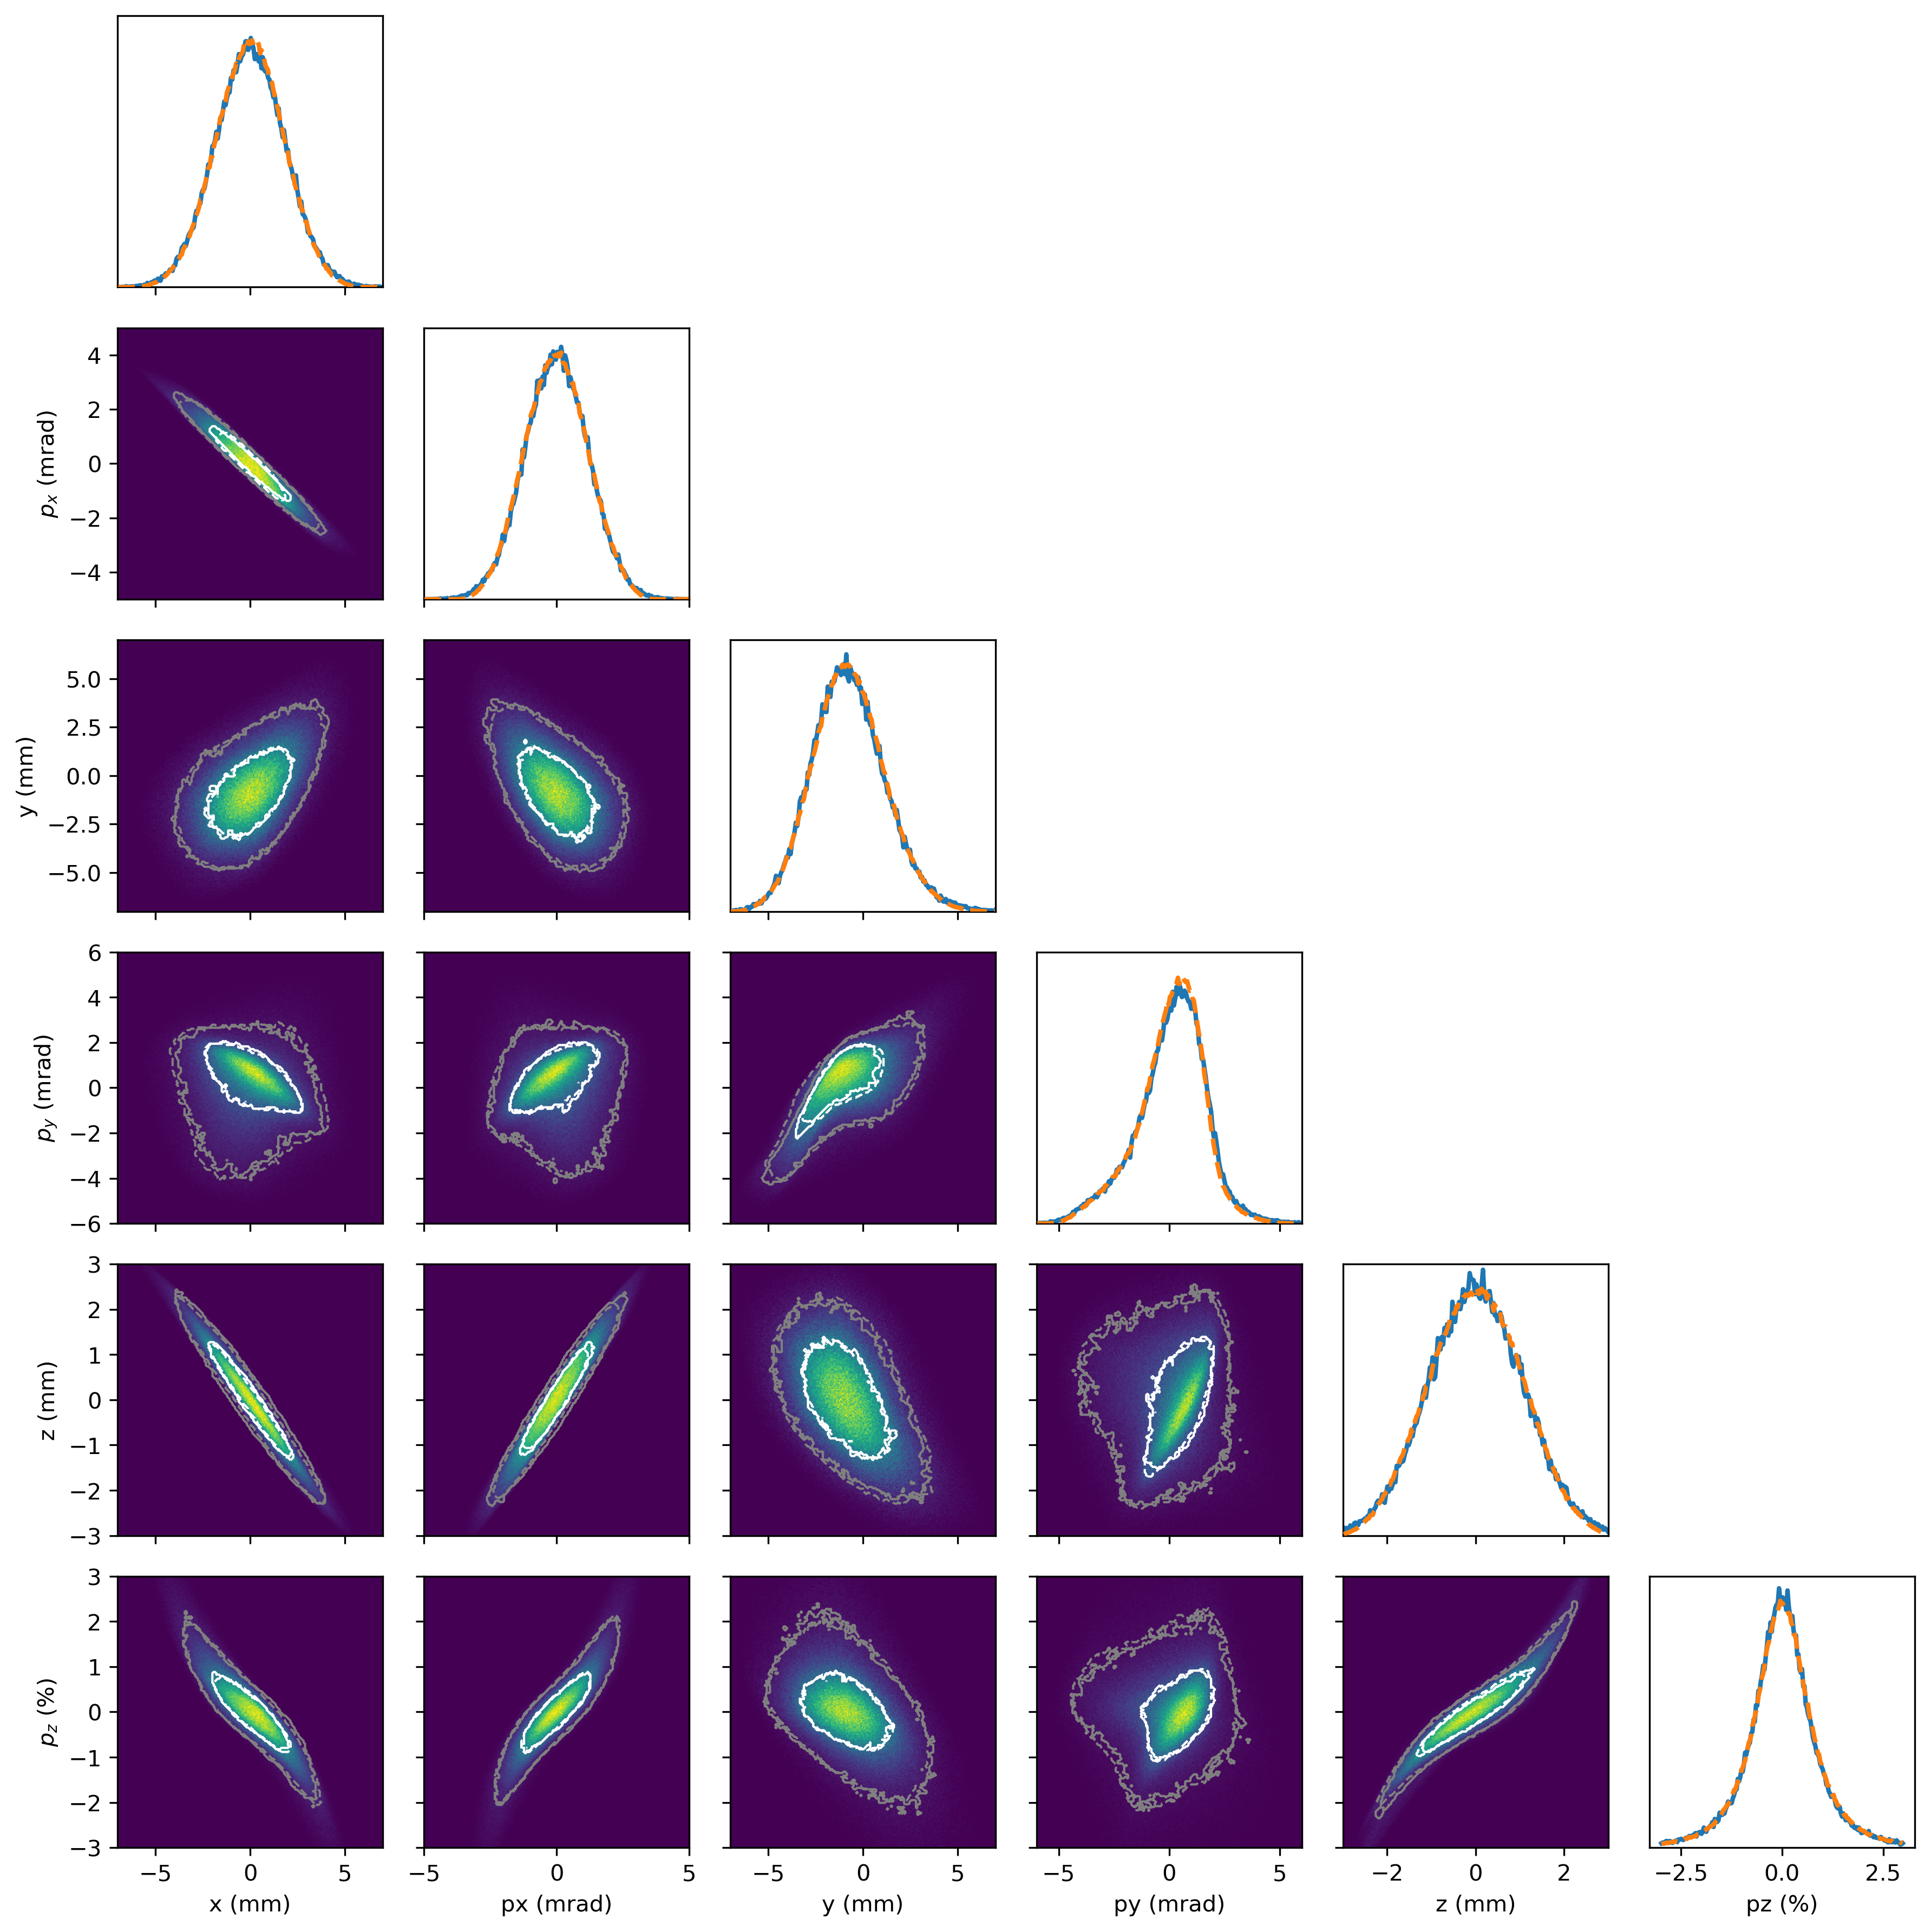

In [9]:
import torch
from stats import plot_projections_with_contours,show_cov_stats
import os

recn_dist = torch.load(os.path.join(save_dir, 'dist_3000.pt'))
recn_dist.data = recn_dist.data
fig,ax = plot_projections_with_contours(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50, 90],
    custom_lims=lims,
    contour_smoothing=0.25,
)

In [10]:
torch.std(recn_dist.data[:,-1])*p0c

tensor(407149.5938)

In [11]:
from stats import plot_projections_with_contours,show_cov_stats,get_cov,plot_cov_sigmas
frac = 0.9
cov_gt_frac = get_cov(gt_beam.numpy_particles(), beam_fraction=frac)
cov_reconstruction_frac = get_cov(recn_dist.numpy_particles(), beam_fraction=frac)

In [12]:
cov_gt_frac

array([[ 2.93239626e-06, -1.87031245e-06,  1.67442314e-06,
        -1.93234974e-07, -1.65660483e-06, -1.34529316e-05],
       [-1.87031245e-06,  1.24617192e-06, -1.07413803e-06,
         1.23310336e-07,  1.07602716e-06,  8.74476302e-06],
       [ 1.67442314e-06, -1.07413803e-06,  3.28409932e-06,
         1.95707743e-06, -9.66947826e-07, -7.82035181e-06],
       [-1.93234974e-07,  1.23310336e-07,  1.95707743e-06,
         2.15200368e-06,  1.09606946e-07,  8.87838417e-07],
       [-1.65660483e-06,  1.07602716e-06, -9.66947826e-07,
         1.09606946e-07,  1.00704621e-06,  8.18887274e-06],
       [-1.34529316e-05,  8.74476302e-06, -7.82035181e-06,
         8.87838417e-07,  8.18887274e-06,  7.36563545e-05]])

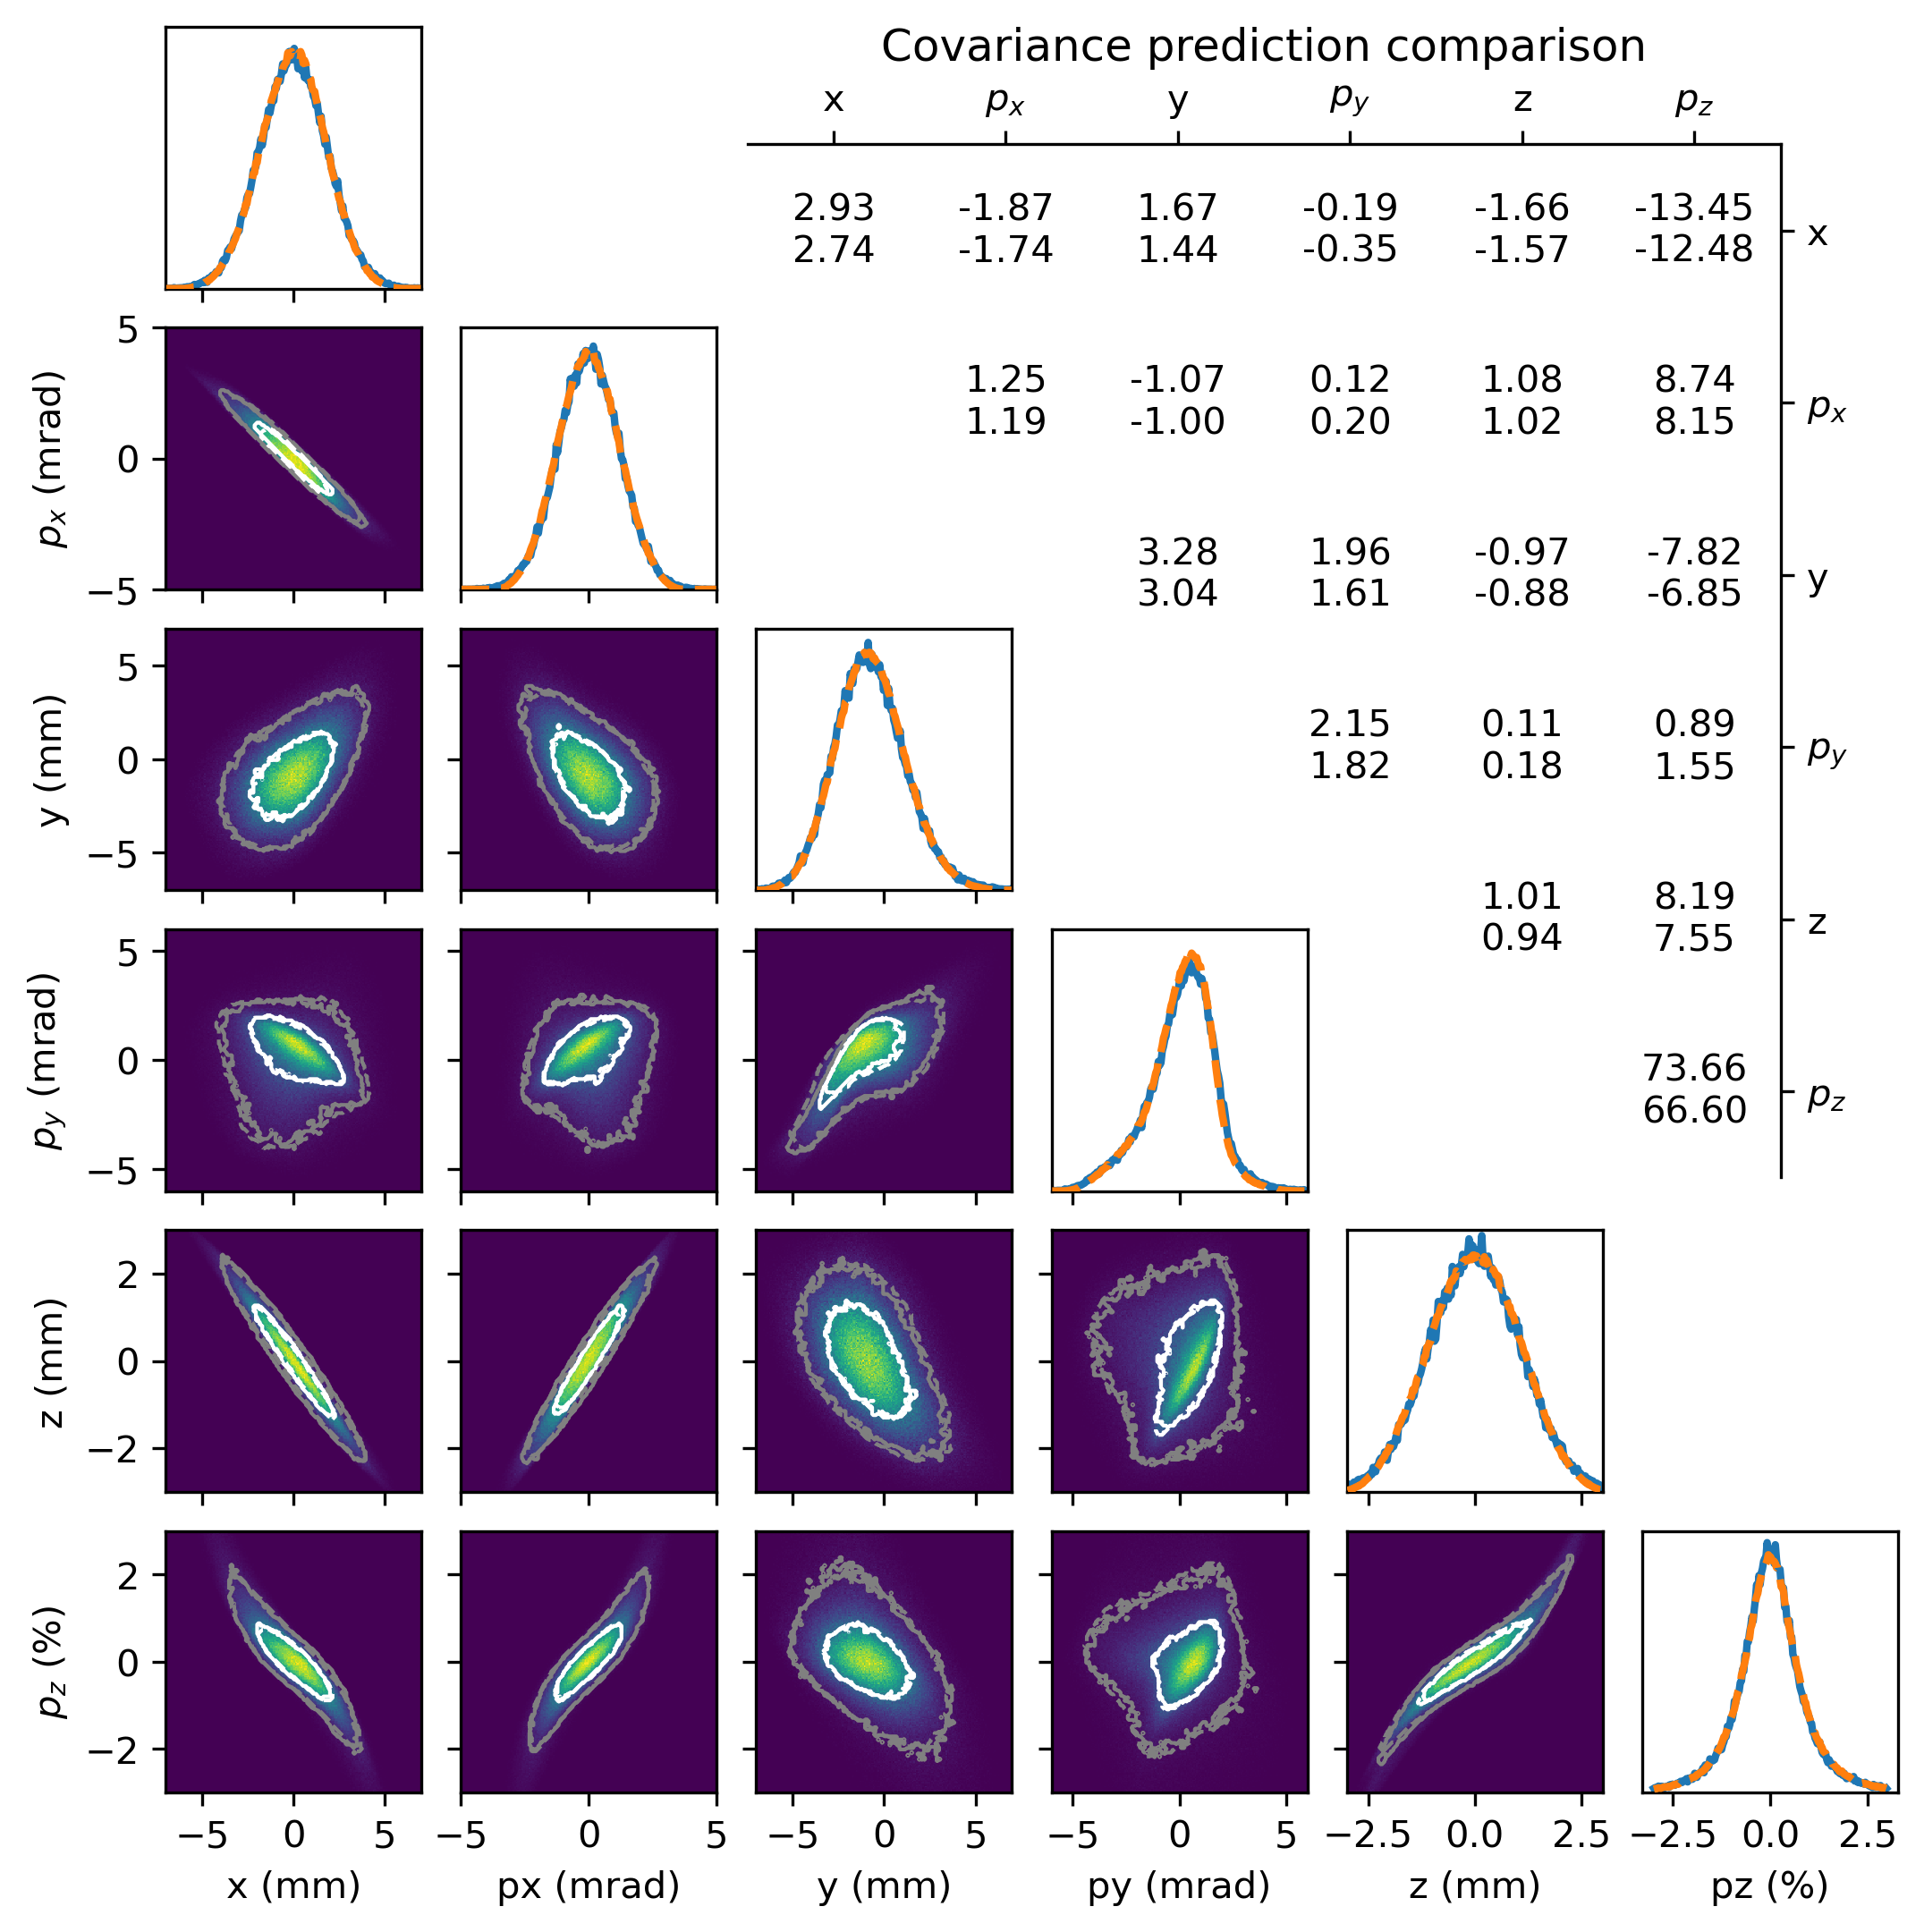

In [13]:
from stats import plot_projections_with_contours,show_cov_stats,get_cov,plot_cov_sigmas
frac = 0.9
cov_gt_frac = get_cov(gt_beam.numpy_particles(), beam_fraction=frac)
cov_reconstruction_frac = get_cov(recn_dist.numpy_particles(), beam_fraction=frac)

frac_error = cov_gt_frac - cov_reconstruction_frac

mask = np.tri(frac_error.shape[0],k=-1)
frac_error = np.flipud(np.ma.array(frac_error, mask=mask))

manipulated_cov_gt = np.flipud(cov_gt_frac).T
manipulated_cov_recon = np.flipud(cov_reconstruction_frac).T


def plot_cov_sigmas(frac_error, fig=None):
    coords = ('x', '$p_x$', 'y', '$p_y$', 'z', '$p_z$')
    
    if fig is None:
        fig, ax = plt.subplots()
    else:
        center = 0.375
        cax_width = 0.025
        buffer = 0.05
        ax_width = 1-center-cax_width - buffer
        ax = fig.add_axes([center, center, ax_width, ax_width],zorder=0)
        #cax = fig.add_axes([center + ax_width + buffer, center, cax_width, ax_width],zorder=0)
        
    c = ax.pcolormesh(manipulated_cov_gt, cmap='seismic', vmin=-100, vmax=100, alpha=0.0)
    for (j,i), label in np.ndenumerate(frac_error):
        if not frac_error.mask[i,j]:
            ax.text(i + 0.5, j + 0.5, f'{manipulated_cov_gt[i,j]*1e6:.2f}\n{manipulated_cov_recon[i,j]*1e6:.2f}', ha='center', va='center')
    #fig.colorbar(c,cax=cax,label="Covariance fractional error")
    ax.set_xticks(np.arange(len(coords))+0.5, labels=coords)
    ax.set_yticks(np.arange(len(coords))+0.5, labels=coords[::-1])
    
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #fig.tight_layout()
    
    ax.set_title("Covariance prediction comparison")

    return fig, ax

fig, ax = plot_cov_sigmas(frac_error,fig)
a = fig.get_axes()[:-10]
for ele in a:
    ele.zorder=10


fig.set_size_inches(7,7)
fig

In [14]:
fig.savefig("nongaussian_reconstruction.svg")
fig.savefig("nongaussian_reconstruction.png", dpi=300)

In [ ]:
frac_error = (cov_gt_frac - cov_reconstruction_frac)/cov_gt_frac

In [ ]:
frac_error

In [ ]:
plt.show()

In [ ]:
fig.set_size_inches(7,7)